

What is the **largest** and most **complete** sample of main-sequence FGK stars we can select?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
from dask.distributed import Client

In [25]:
# Access astronomical databases
from pyvo import registry  # version >=1.4.1 

# Moc and HEALPix tools
from mocpy import MOC

# Sky visualization
from ipyaladin import Aladin

In [26]:
# the catalogue name in VizieR
CATALOGUE = "I/354"

# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

# We can also extract the tables names for later use
tables_names = list(tables.keys())

In [292]:
%%time
# get the first table of the catalogue
first_table_name = tables_names[0]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(
f'SELECT TOP 1 Source, RA_ICRS, DE_ICRS, teff50,\
logg50, met50, dist50, fidelity, GMAG0, "BP-RP0" from "{first_table_name}" WHERE (logg50>4.3) AND \
(logg50<4.72) AND (teff50<7220) AND \
(teff50>4000) AND (DE_ICRS BETWEEN 70 AND 80) AND (fidelity>=0.5)',
) # ran on Feb 17 1PM

CPU times: user 22.6 ms, sys: 9.88 ms, total: 32.5 ms
Wall time: 798 ms


In [293]:
tbl = tap_records.to_table().to_pandas()

In [294]:
s1 = dask.dataframe.from_pandas(tbl, npartitions=20)

In [295]:
m1 = dask.dataframe.concat([s1])

In [296]:
m1.compute()

,Source,RA_ICRS,DE_ICRS,teff50,logg50,met50,dist50,fidelity,GMAG0,BP-RP0
0,533052071900130560,14.864803,70.0,5008.14,4.552187,0.166454,1.019806,1.0,5.779356,1.168783


In [298]:
bin_intervals = [90, 80, 70, 60, 50, 40, 30, 20, 15, 10, 5, 4, 3, 
                 2, 1, 0, -1, -2, -3, -4, -5, -6, -7, -8, -10, -15, -20, -25, -30, -40,]

In [299]:
from tqdm import tqdm

In [300]:
%%time
for i in tqdm(range(len(bin_intervals)-1)):
    start, end = bin_intervals[i+1], bin_intervals[i]
    print (f"Now running {start}, {end}")

    tap_records = voresource.get_service("tap").run_sync(
    f'SELECT Source, RA_ICRS, DE_ICRS, teff50,\
    logg50, met50, dist50, fidelity, GMAG0, "BP-RP0" from "{first_table_name}" WHERE (logg50>4.3) AND \
    (logg50<4.72) AND (teff50<7220) AND \
    (teff50>4000) AND (DE_ICRS BETWEEN {start} AND {end}) AND (fidelity>=0.5)',
    ) # ran on Feb 17 1PM
    
    tbl = tap_records.to_table().to_pandas()
    s_new = dask.dataframe.from_pandas(tbl, npartitions=20)
    
    m1 = dask.dataframe.concat([s_new, m1])
    

  0%|          | 0/29 [00:00<?, ?it/s]

Now running 80, 90


  3%|▎         | 1/29 [00:26<12:33, 26.91s/it]

Now running 70, 80


  7%|▋         | 2/29 [01:42<25:06, 55.80s/it]

Now running 60, 70


 10%|█         | 3/29 [04:11<42:36, 98.31s/it]

Now running 50, 60


 14%|█▍        | 4/29 [08:42<1:09:15, 166.24s/it]

Now running 40, 50


 17%|█▋        | 5/29 [14:41<1:34:20, 235.84s/it]

Now running 30, 40


 21%|██        | 6/29 [24:17<2:14:48, 351.66s/it]

Now running 20, 30


 24%|██▍       | 7/29 [30:54<2:14:18, 366.29s/it]

Now running 15, 20


 28%|██▊       | 8/29 [36:58<2:08:00, 365.71s/it]

Now running 10, 15


 31%|███       | 9/29 [40:32<1:46:00, 318.04s/it]

Now running 5, 10


 34%|███▍      | 10/29 [43:56<1:29:36, 282.98s/it]

Now running 4, 5


 38%|███▊      | 11/29 [45:42<1:08:40, 228.93s/it]

Now running 3, 4


 41%|████▏     | 12/29 [46:21<48:27, 171.01s/it]  

Now running 2, 3


 45%|████▍     | 13/29 [46:59<34:52, 130.79s/it]

Now running 1, 2


 48%|████▊     | 14/29 [49:46<35:24, 141.66s/it]

Now running 0, 1


 52%|█████▏    | 15/29 [51:41<31:11, 133.69s/it]

Now running -1, 0


 55%|█████▌    | 16/29 [52:24<23:00, 106.22s/it]

Now running -2, -1


 59%|█████▊    | 17/29 [53:05<17:21, 86.79s/it] 

Now running -3, -2


 62%|██████▏   | 18/29 [55:03<17:35, 95.97s/it]

Now running -4, -3


 66%|██████▌   | 19/29 [56:51<16:36, 99.68s/it]

Now running -5, -4


 69%|██████▉   | 20/29 [57:29<12:11, 81.28s/it]

Now running -6, -5


 72%|███████▏  | 21/29 [58:08<09:07, 68.46s/it]

Now running -7, -6


 76%|███████▌  | 22/29 [1:00:30<10:34, 90.69s/it]

Now running -8, -7


 79%|███████▉  | 23/29 [1:02:45<10:23, 103.84s/it]

Now running -10, -8


 83%|████████▎ | 24/29 [1:04:04<08:02, 96.47s/it] 

Now running -15, -10


 86%|████████▌ | 25/29 [1:10:55<12:43, 190.75s/it]

Now running -20, -15


 90%|████████▉ | 26/29 [1:14:24<09:48, 196.32s/it]

Now running -25, -20


 93%|█████████▎| 27/29 [1:18:13<06:52, 206.07s/it]

Now running -30, -25


 97%|█████████▋| 28/29 [1:22:09<03:35, 215.05s/it]

Now running -40, -30


100%|██████████| 29/29 [1:29:37<00:00, 185.44s/it]

CPU times: user 1h 6min 25s, sys: 1min 47s, total: 1h 8min 13s
Wall time: 1h 29min 37s


In [301]:
%%time
ff = m1.compute()

CPU times: user 2.57 s, sys: 7.74 s, total: 10.3 s
Wall time: 10.3 s


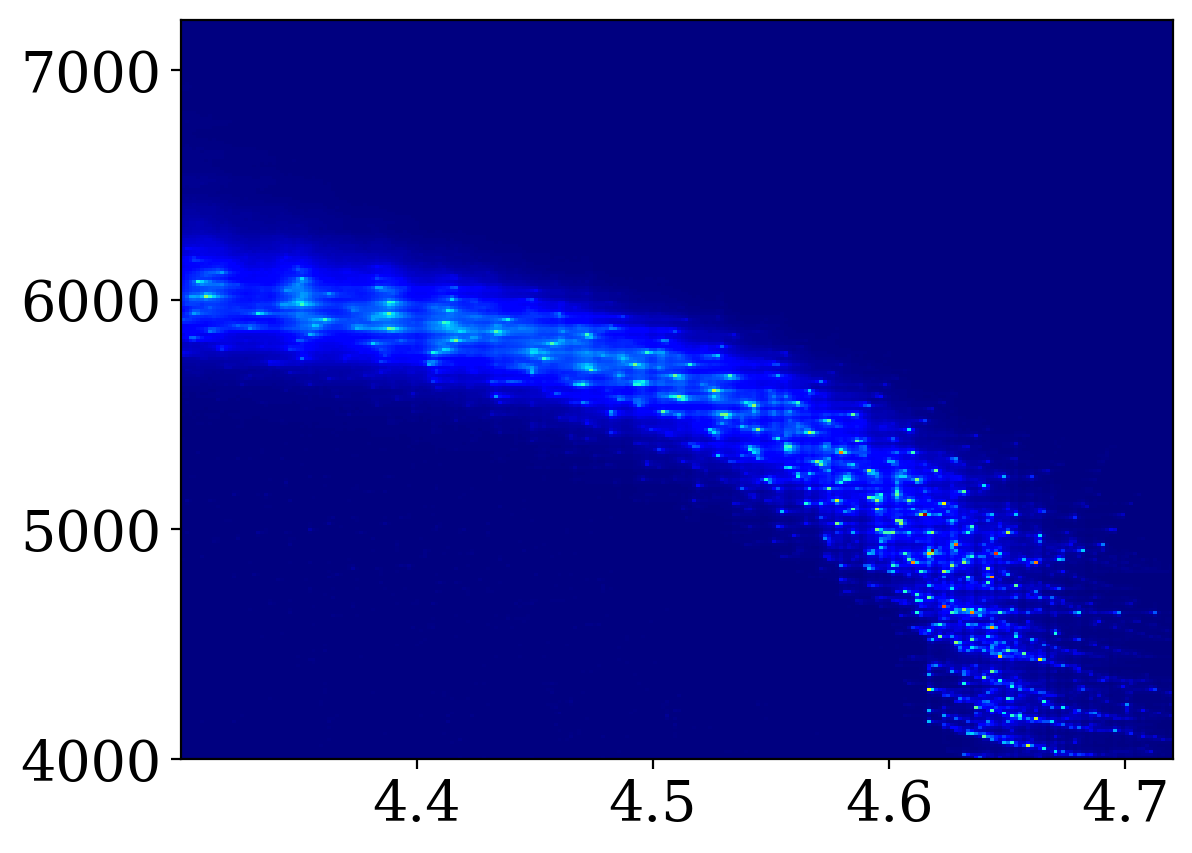

In [313]:
H = plt.hist2d(ff['logg50'], ff['teff50'], bins=(250, 250), cmap='jet')

/tmp/ipykernel_57344/1308783363.py:1: RuntimeWarning: divide by zero encountered in log10
  _ = plt.imshow(np.log10(H[0]),


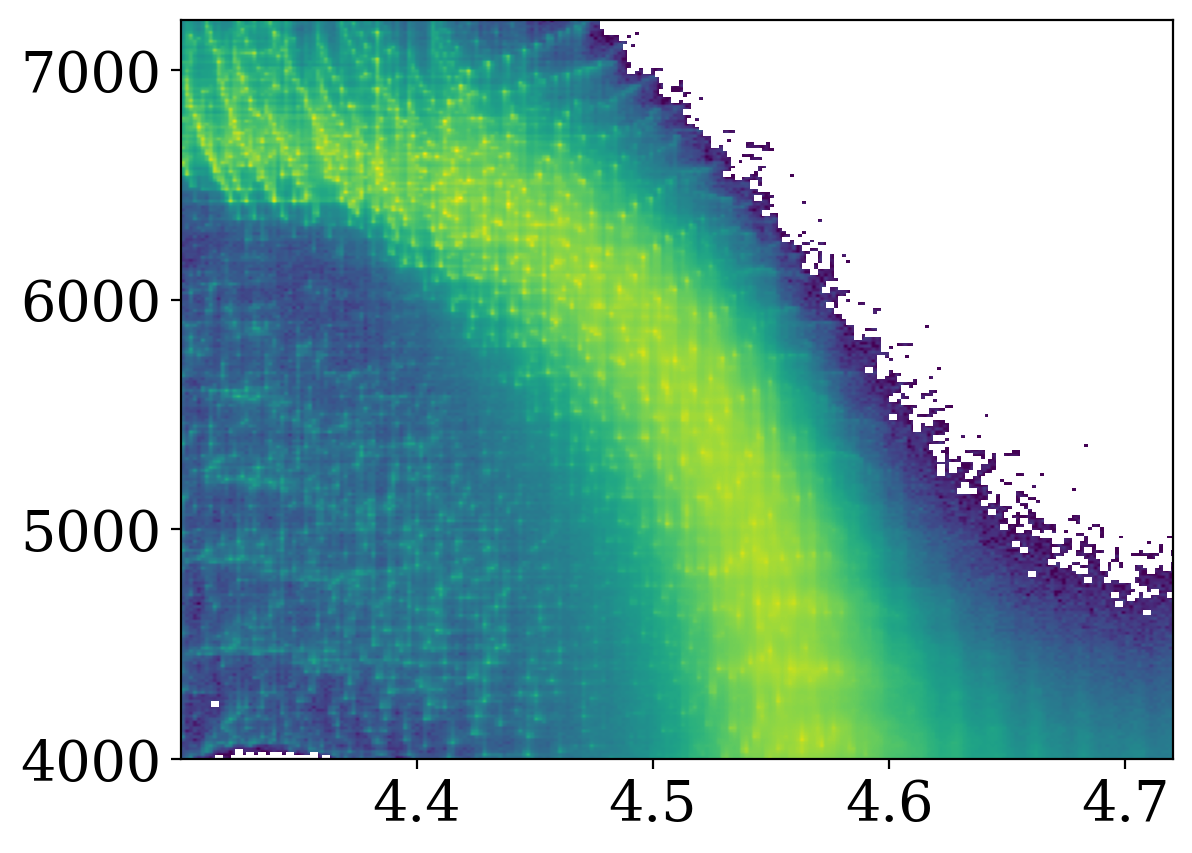

In [330]:
_ = plt.imshow(np.log10(H[0]), 
              extent=[min(ff['logg50']), max(ff['logg50']),min(ff['teff50']), max(ff['teff50'])], 
              aspect='auto', origin='lower')

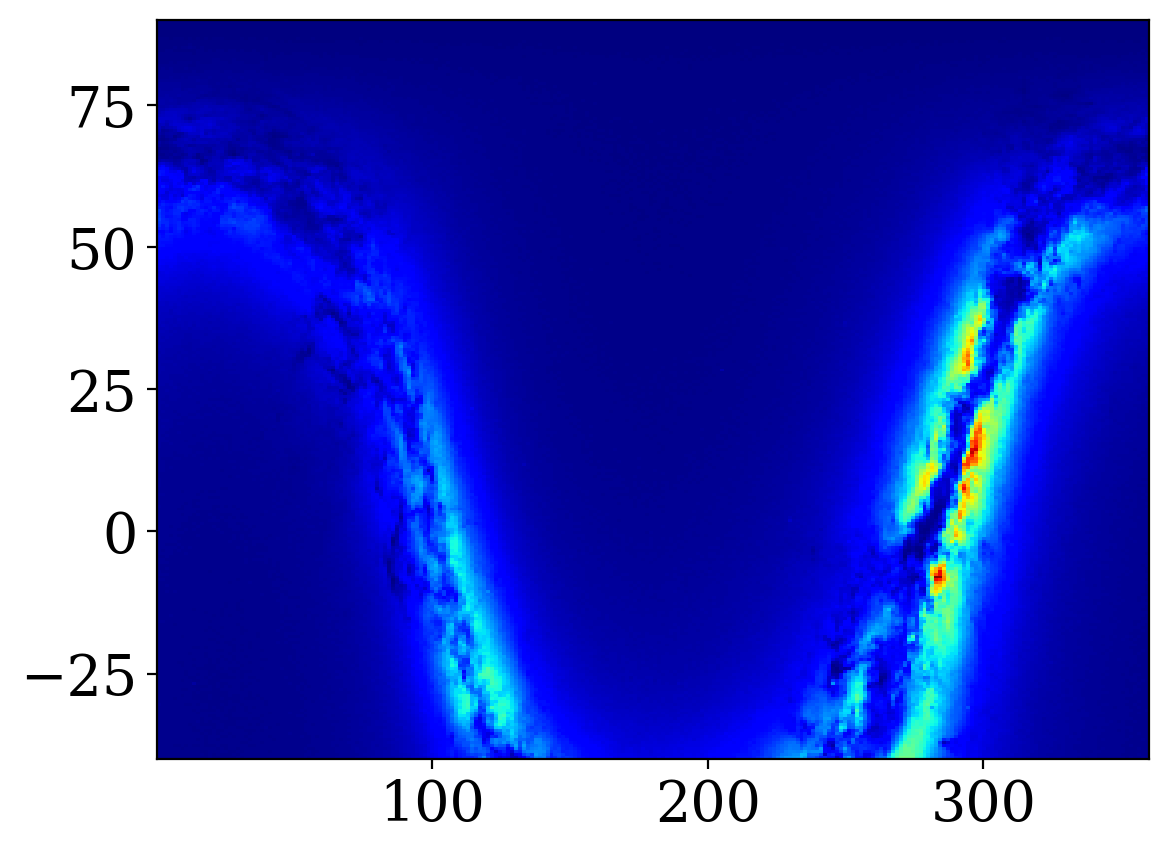

In [309]:
_ = plt.hist2d(ff['RA_ICRS'], ff['DE_ICRS'], bins=(250, 250), cmap='jet')

In [306]:
# storerd on Feb. 17 5:21pm

In [307]:
%%time
ff.to_parquet("/epyc/ssd/users/atzanida/tmp/starH24/StarHorseFGK.parquet", engine='pyarrow')

CPU times: user 42.9 s, sys: 42.2 s, total: 1min 25s
Wall time: 1min 4s
